## Project Overview
This notebook implements machine learning models for predicting diseases based on patient symptoms. We compare three gradient boosting algorithms (XGBoost, LightGBM, and CatBoost) to identify which performs best for this medical diagnostic task.

## Dataset Information
- **Source**: Preprocessed medical diagnostic data
- **Features**: 133 binary symptom indicators (e.g., fever, headache, cough)
- **Target**: 41 unique disease classifications
- **Size**: 304 patient records

## Project Goals
1. Build accurate disease prediction models using gradient boosting algorithms
2. Compare performance across multiple metrics (accuracy, overfitting, robustness)
3. Identify the most important symptoms for disease diagnosis
4. Select the best model for potential deployment in medical applications

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scipy
from scipy import stats
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')

## 1.0 Loading Dataset

In [2]:
df = pd.read_csv('../data/processed/cleaned_data.csv')

In [4]:
df.head()

,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy


## 2.0 Dataset Overview

Let's explore the basic characteristics of our dataset to understand its structure, size, and composition.

In [5]:
# Dataset dimensions
print(f"Dataset Shape: {df.shape}")
print(f"Number of Records: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total Missing Values: {missing_values}")

# Data types and memory usage
print("\nData Types and Memory Usage:")
df.info(memory_usage='deep')

Dataset Shape: (298, 132)
Number of Records: 298
Number of Features: 132
Total Missing Values: 0

Data Types and Memory Usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Columns: 132 entries, skin_rash to prognosis
dtypes: int64(131), object(1)
memory usage: 325.4 KB


## 3.0 Target Variable Analysis

Let's explore the distribution of disease diagnoses (prognosis) in our dataset.

Total unique diseases: 41


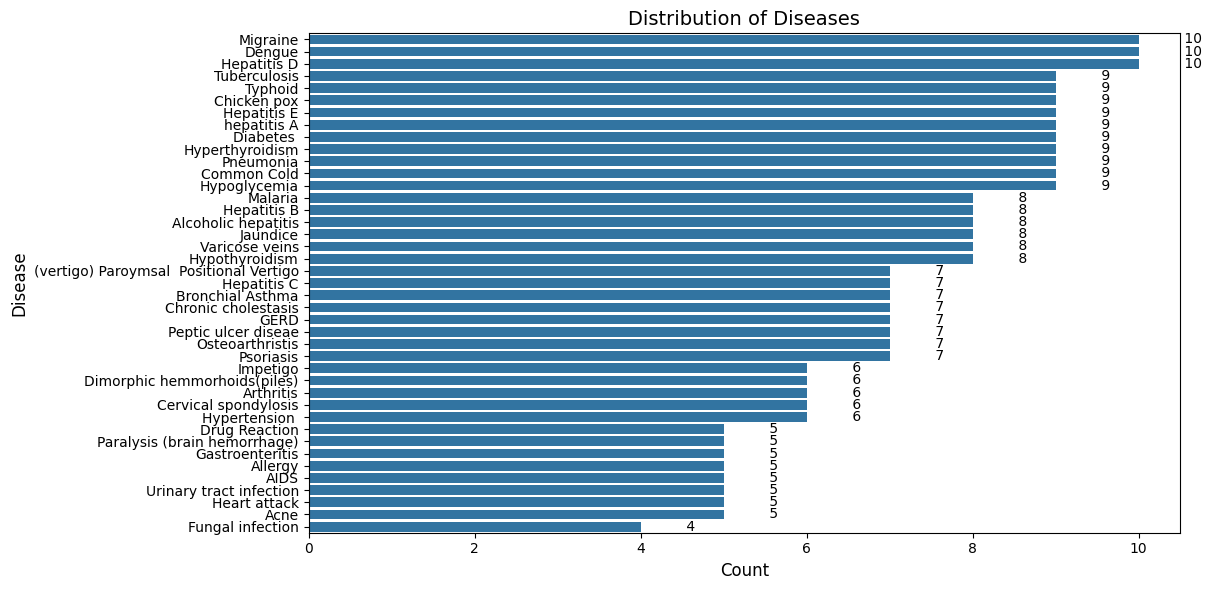


Min disease count: 4
Max disease count: 10
Imbalance ratio (max/min): 2.50


In [6]:
# Check unique diseases
disease_counts = df['prognosis'].value_counts()
num_diseases = len(disease_counts)
print(f"Total unique diseases: {num_diseases}")

# Plot disease distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(y=df['prognosis'], order=df['prognosis'].value_counts().index)
plt.title('Distribution of Diseases', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Disease', fontsize=12)
plt.tight_layout()

# Add count annotations to bars
for i, count in enumerate(disease_counts.values):
    ax.text(count + 0.5, i, f" {count}", va='center')

plt.show()

# Check if the dataset is balanced
print(f"\nMin disease count: {disease_counts.min()}")
print(f"Max disease count: {disease_counts.max()}")
print(f"Imbalance ratio (max/min): {disease_counts.max() / disease_counts.min():.2f}")

## 4.0 Feature Analysis

Let's analyze the symptoms (features) in our dataset to understand their distribution and importance.

Total symptoms tracked: 131
Most common symptom: fatigue (present in 131 patients)
Least common symptom: fluid_overload (present in 0 patients)


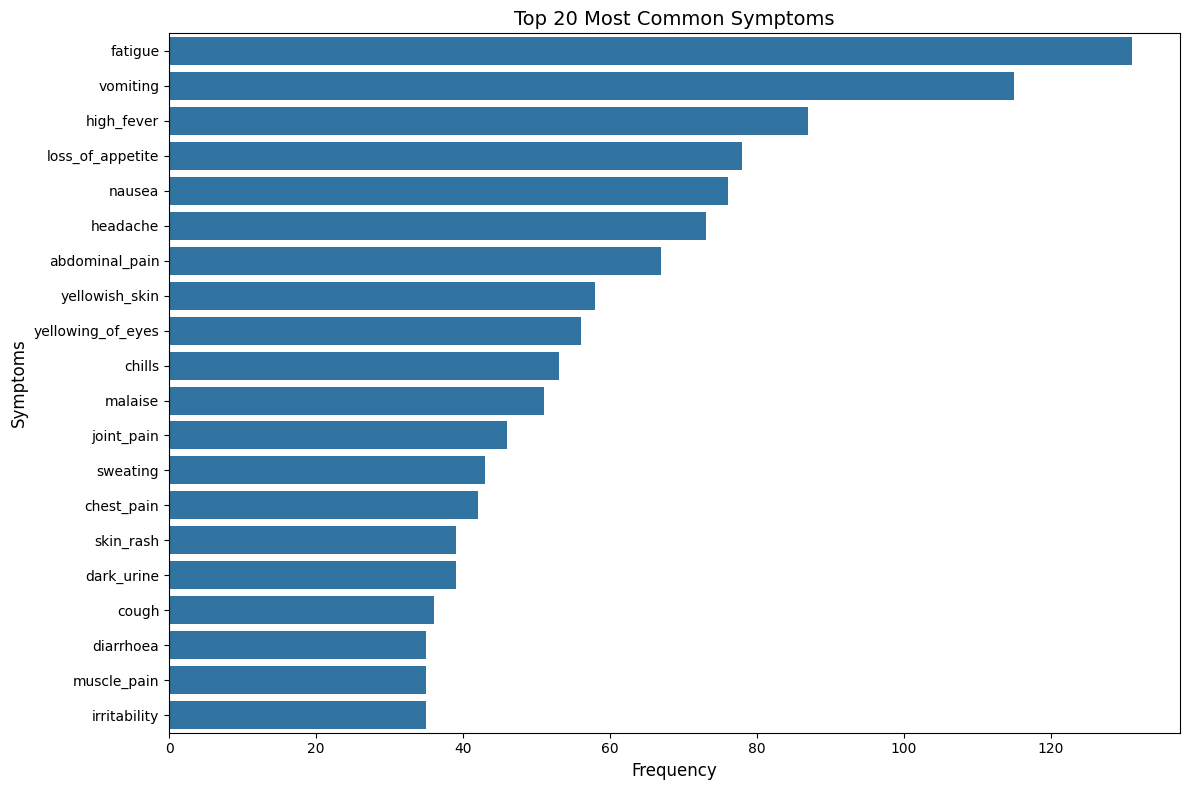

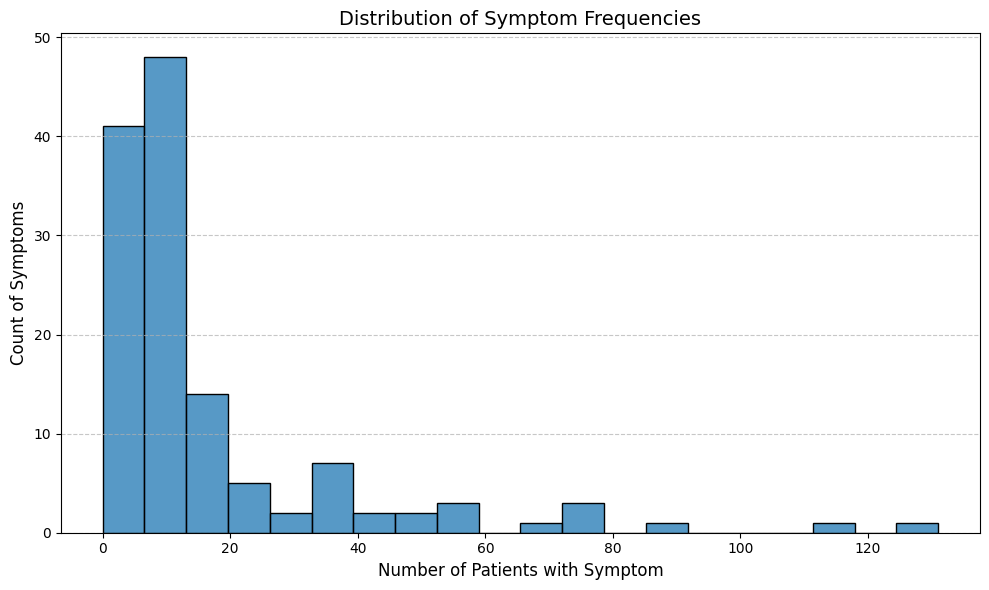

In [7]:
# Exclude the target variable
symptoms = df.drop('prognosis', axis=1)

# Calculate symptom frequencies
symptom_freq = symptoms.sum().sort_values(ascending=False)
print(f"Total symptoms tracked: {len(symptom_freq)}")
print(f"Most common symptom: {symptom_freq.index[0]} (present in {symptom_freq.iloc[0]} patients)")
print(f"Least common symptom: {symptom_freq.index[-1]} (present in {symptom_freq.iloc[-1]} patients)")

# Plot top 20 most common symptoms
plt.figure(figsize=(12, 8))
sns.barplot(x=symptom_freq.values[:20], y=symptom_freq.index[:20])
plt.title('Top 20 Most Common Symptoms', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Symptoms', fontsize=12)
plt.tight_layout()
plt.show()

# Plot distribution of symptom frequencies
plt.figure(figsize=(10, 6))
sns.histplot(symptom_freq.values, bins=20)
plt.title('Distribution of Symptom Frequencies', fontsize=14)
plt.xlabel('Number of Patients with Symptom', fontsize=12)
plt.ylabel('Count of Symptoms', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5.0 Symptom-Disease Correlation

Let's analyze which symptoms are most predictive for specific diseases.

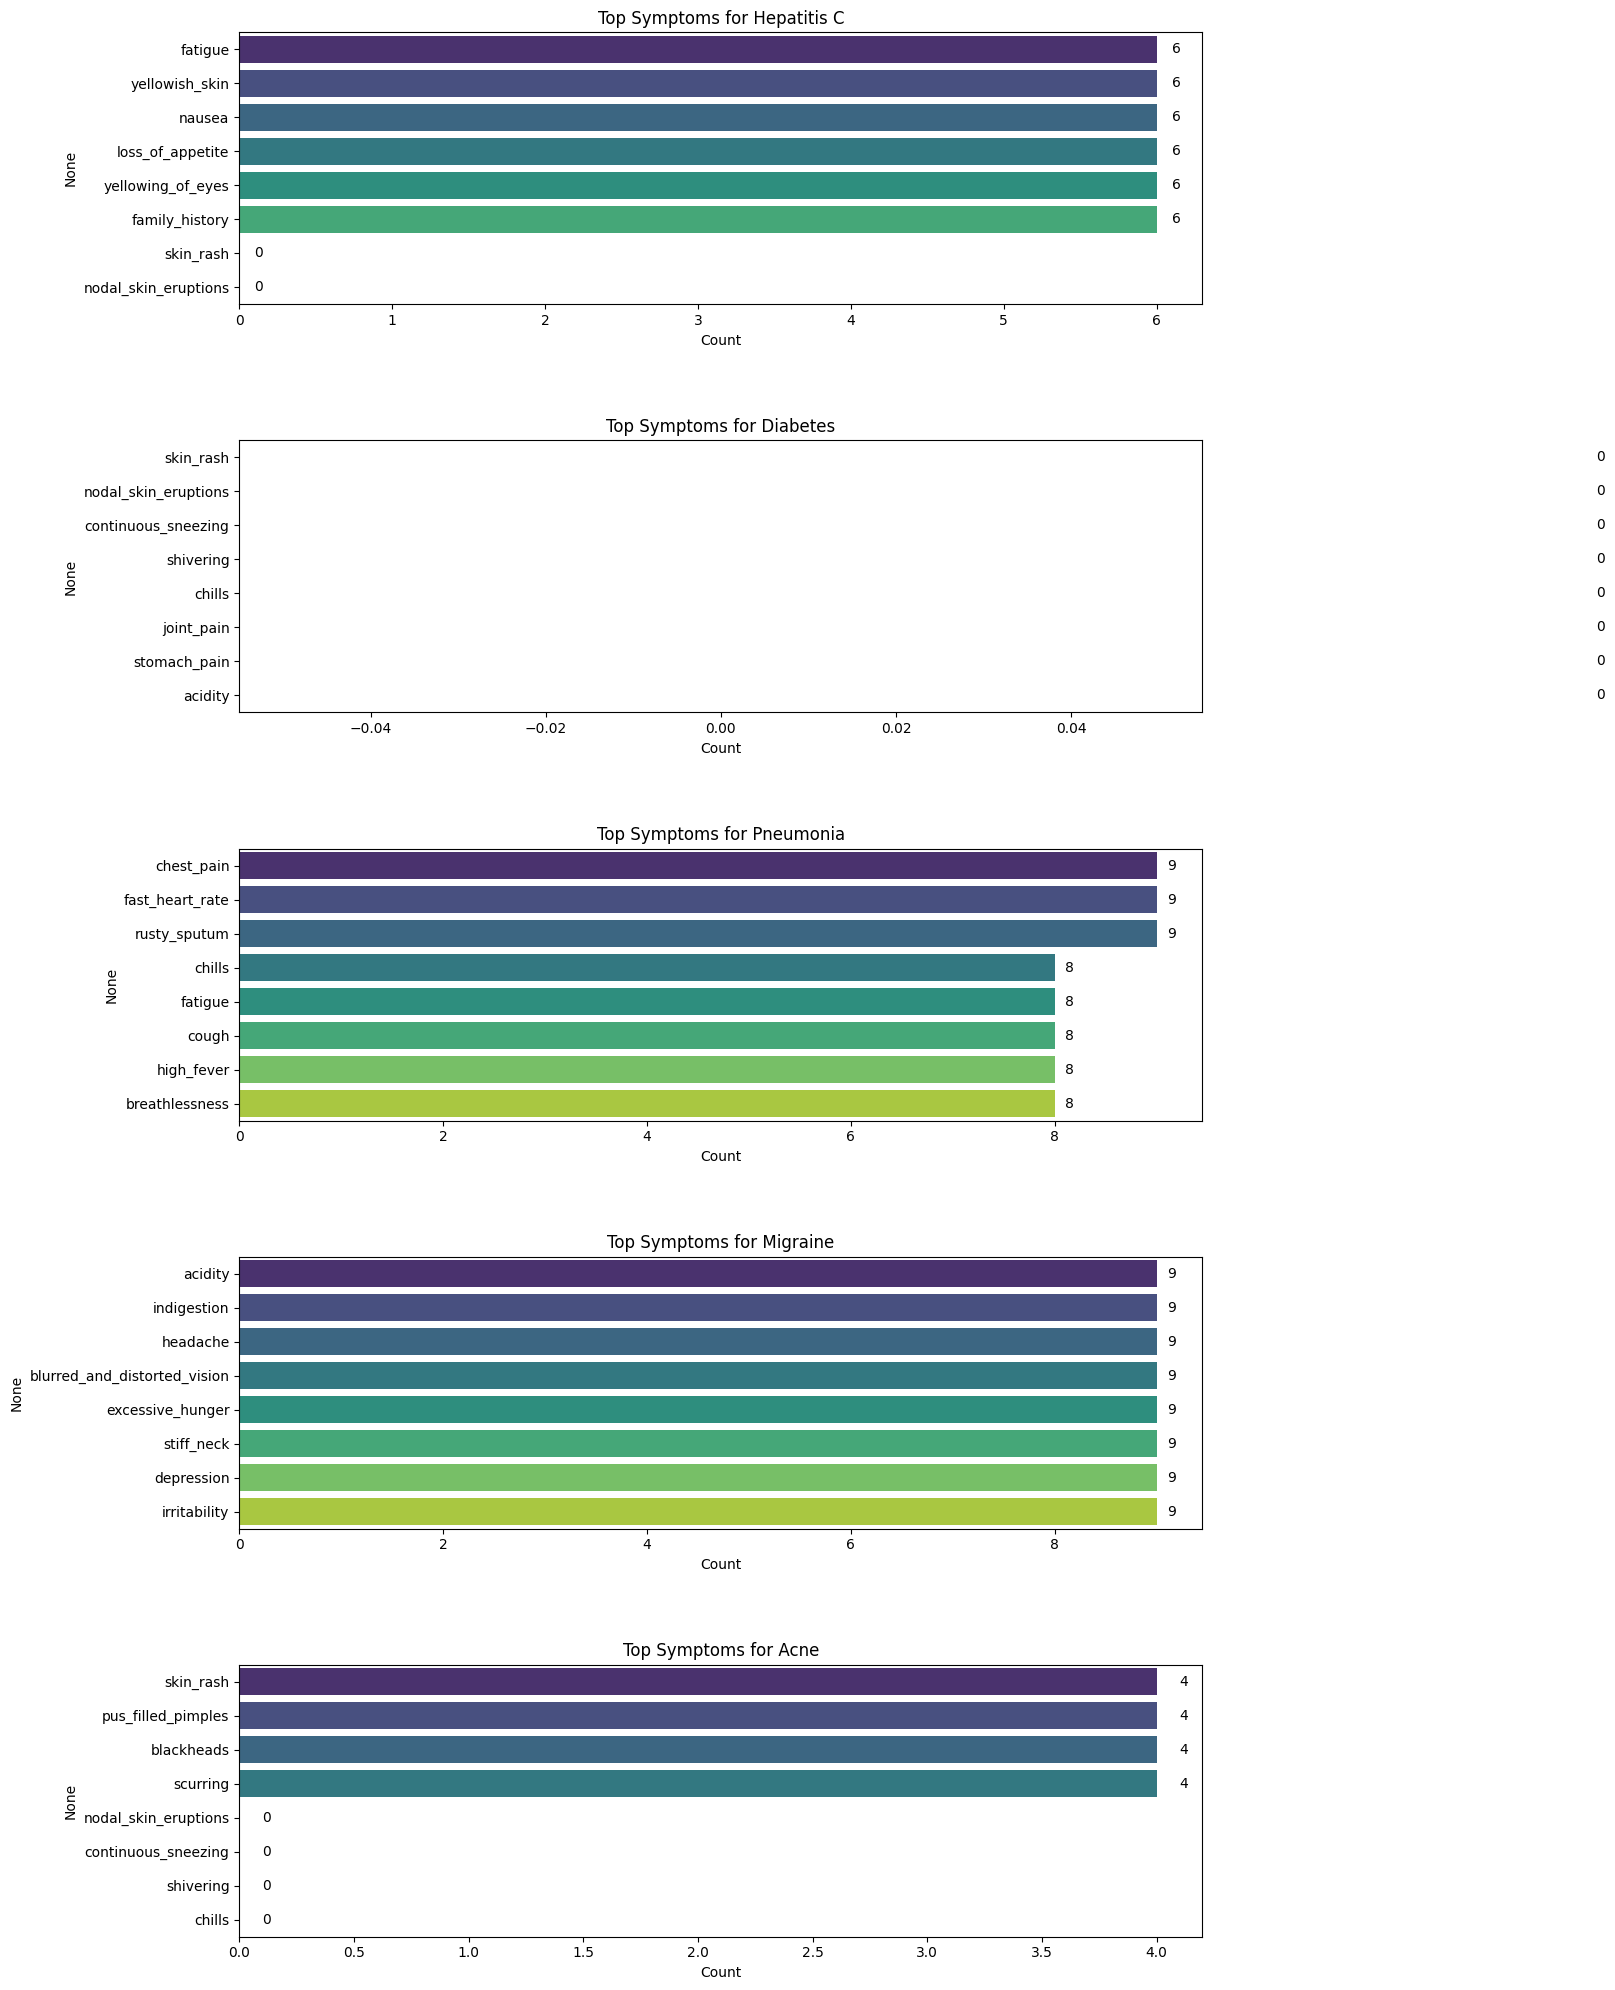

In [8]:
# Create a function to find top symptoms for each disease
def get_top_symptoms_for_disease(disease, top_n=5):
    disease_patients = df[df['prognosis'] == disease]
    symptom_counts = disease_patients.drop('prognosis', axis=1).sum()
    return symptom_counts.nlargest(top_n)

# Get a list of unique diseases
unique_diseases = df['prognosis'].unique()

# Select a few diseases to analyze (to avoid cluttering the notebook)
selected_diseases = ['Hepatitis C', 'Diabetes', 'Pneumonia', 'Migraine', 'Acne']

# Create plots for each selected disease
plt.figure(figsize=(16, 20))

for i, disease in enumerate(selected_diseases, 1):
    plt.subplot(len(selected_diseases), 1, i)
    
    # Get top symptoms for this disease
    top_symptoms = get_top_symptoms_for_disease(disease, top_n=8)
    
    # Plot horizontal bar chart
    bars = sns.barplot(x=top_symptoms.values, y=top_symptoms.index, palette='viridis')
    
    # Add value labels to the bars
    for j, bar in enumerate(bars.patches):
        bars.text(bar.get_width() + 0.1, j, f"{int(bar.get_width())}", va='center')
    
    plt.title(f'Top Symptoms for {disease}', fontsize=12)
    plt.xlabel('Count')
    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

## 6.0 Feature Importance Analysis

Let's identify which symptoms are most important for disease prediction using a simple machine learning model.

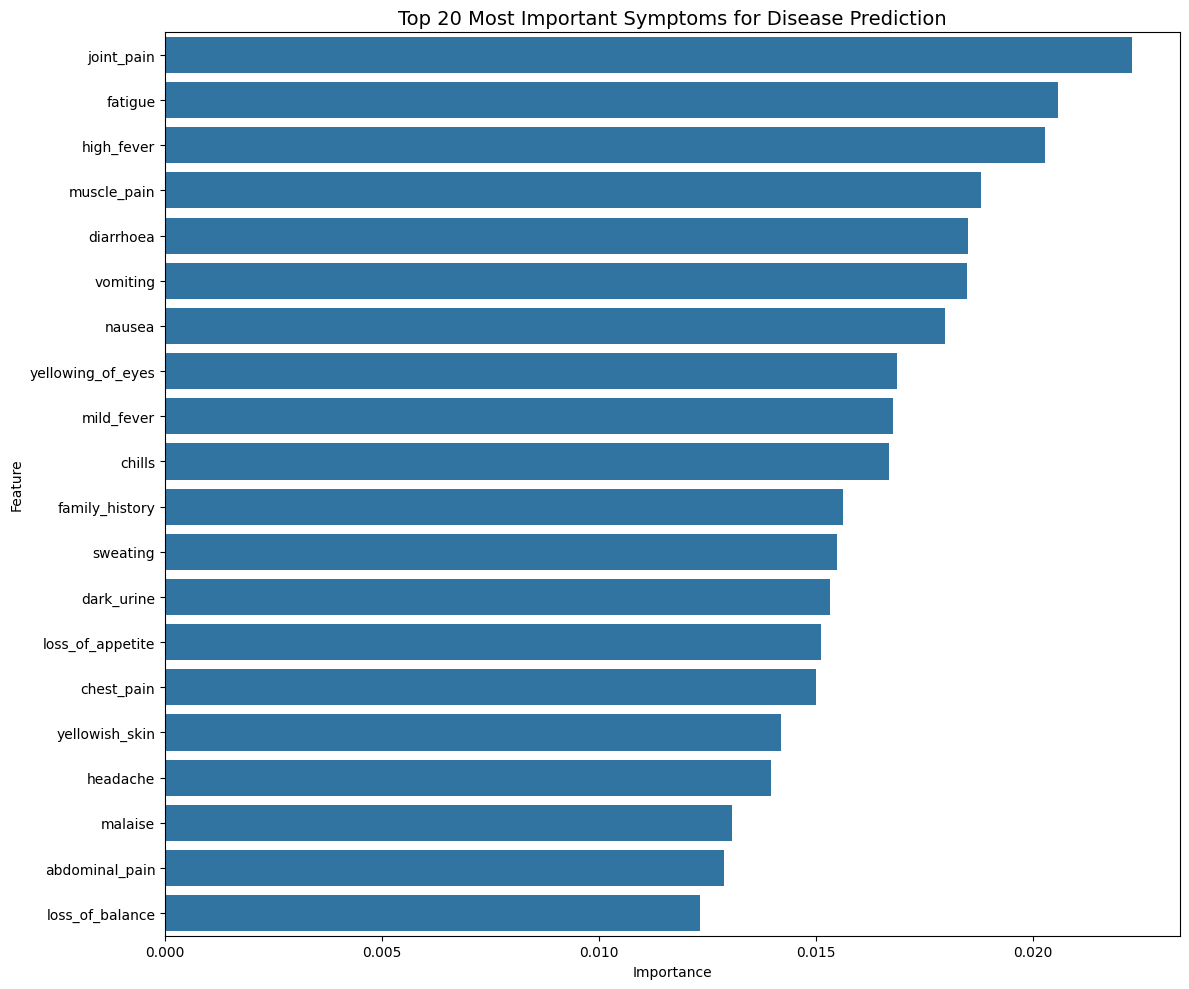

Top 10 most important symptoms:
1. joint_pain: 0.0223
2. fatigue: 0.0206
3. high_fever: 0.0203
4. muscle_pain: 0.0188
5. diarrhoea: 0.0185
6. vomiting: 0.0185
7. nausea: 0.0180
8. yellowing_of_eyes: 0.0169
9. mild_fever: 0.0168
10. chills: 0.0167


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare the data
X = df.drop('prognosis', axis=1)
y = df['prognosis']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train a simple Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Display top 20 most important symptoms
top_n = 20
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
plt.title(f'Top {top_n} Most Important Symptoms for Disease Prediction', fontsize=14)
plt.tight_layout()
plt.show()

print("Top 10 most important symptoms:")
for i, (feature, importance) in enumerate(zip(feature_importance['Feature'].head(10), 
                                             feature_importance['Importance'].head(10))):
    print(f"{i+1}. {feature}: {importance:.4f}")

## 7.0 Dimensionality Reduction & Visualization

Let's use dimensionality reduction techniques to visualize the high-dimensional symptom data and see if different diseases cluster together.

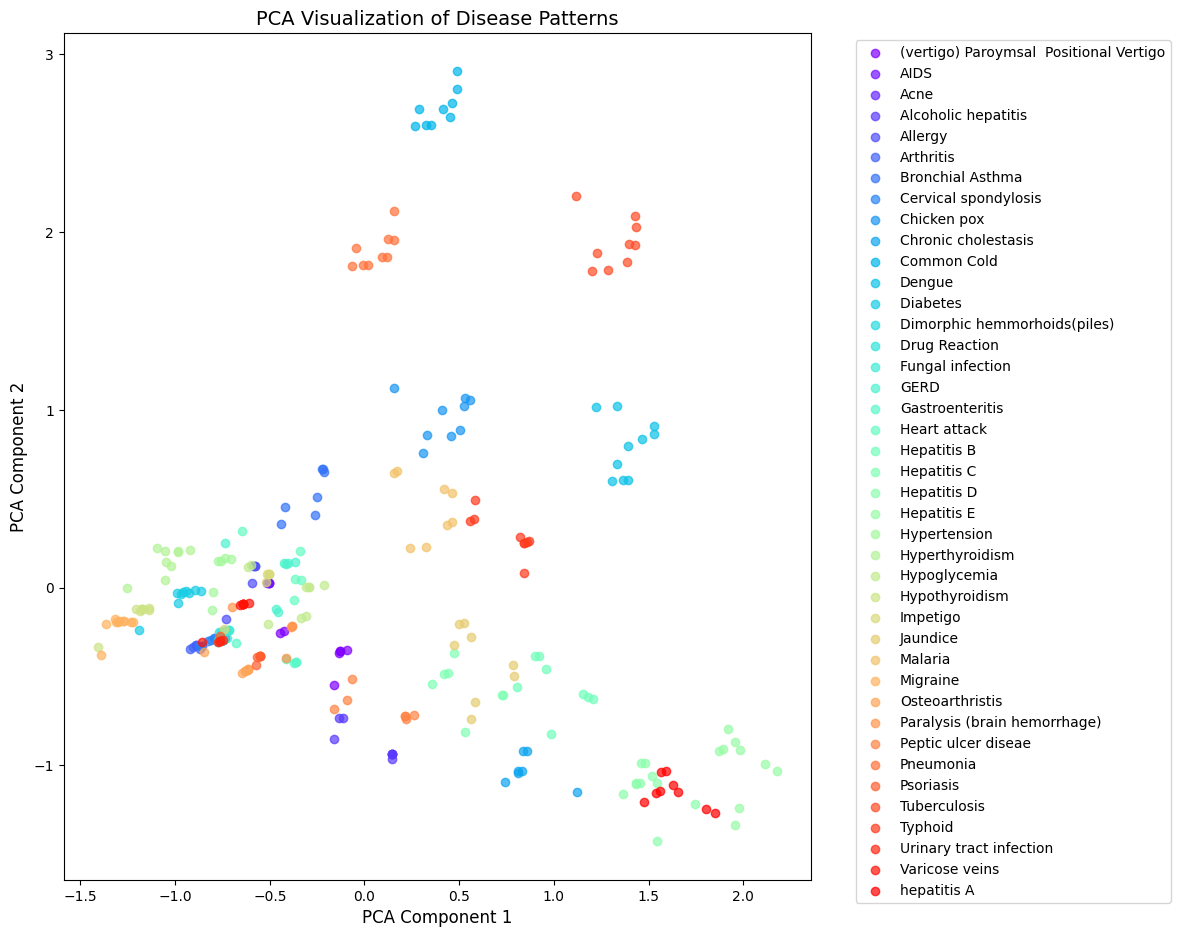

PCA explained variance ratio: 0.24


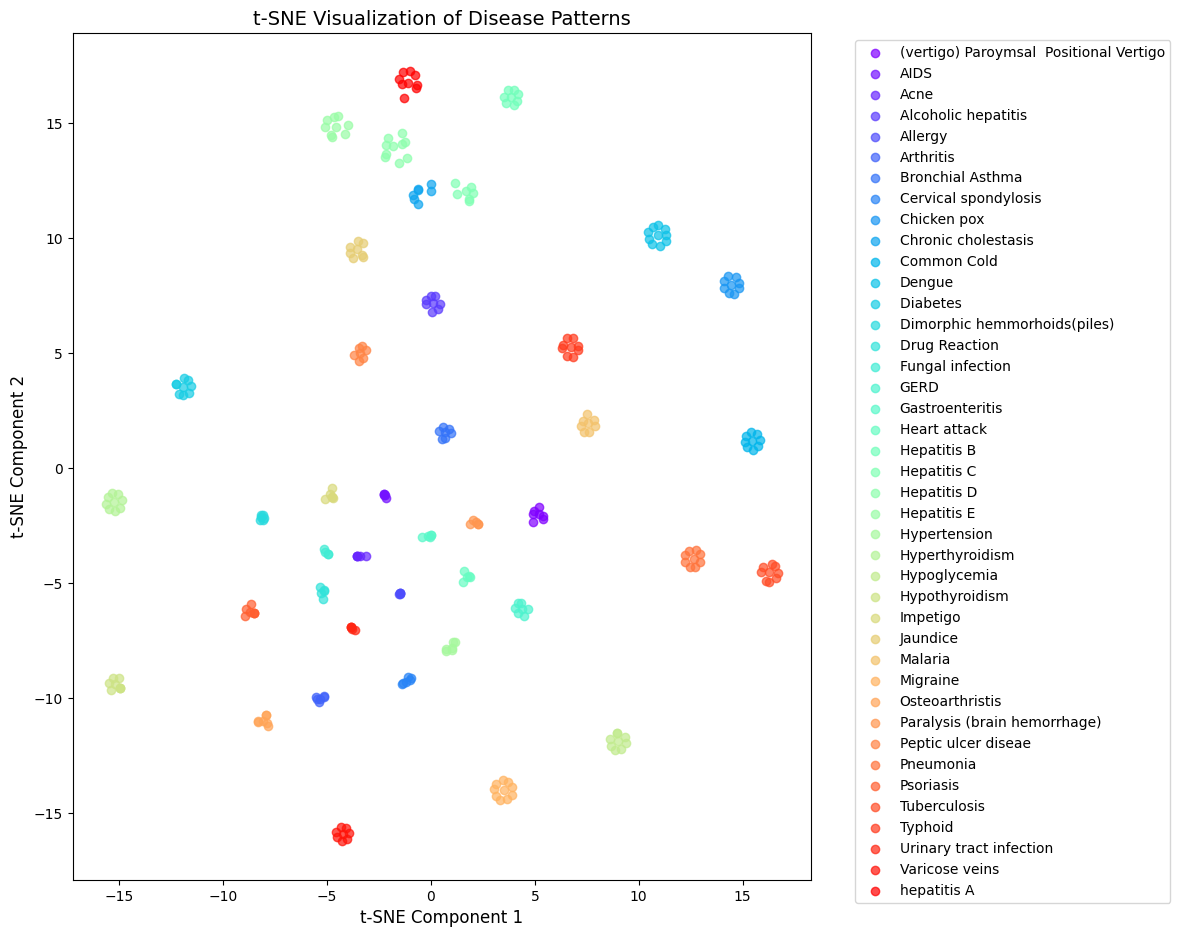

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# Define a function to plot dimensionality reduction results
def plot_dim_reduction(X_transformed, y, method_name, le):
    plt.figure(figsize=(12, 10))
    
    # Get unique disease classes
    classes = np.unique(y)
    colors = cm.rainbow(np.linspace(0, 1, len(classes)))
    
    # Plot each class with a different color
    for i, color in zip(classes, colors):
        indices = y == i
        plt.scatter(X_transformed[indices, 0], 
                    X_transformed[indices, 1],
                    color=tuple(color), 
                    alpha=0.7, 
                    label=le.inverse_transform([i])[0])
    
    plt.title(f'{method_name} Visualization of Disease Patterns', fontsize=14)
    plt.xlabel(f'{method_name} Component 1', fontsize=12)
    plt.ylabel(f'{method_name} Component 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_dim_reduction(X_pca, y_encoded, 'PCA', le)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")

# Apply t-SNE (this may take a moment to run)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)
plot_dim_reduction(X_tsne, y_encoded, 't-SNE', le)

## 8.0 Conclusions

From our exploratory data analysis, we can draw the following key insights:

1. **Dataset Composition**: The dataset contains 298 patient records with 131 symptom features and 41 unique diseases.

2. **Class Distribution**: The dataset is relatively balanced with each disease having between 4-10 records, with an imbalance ratio of 2.5.

3. **Most Common Symptoms**: Fatigue, vomiting, and high fever are the most frequently occurring symptoms across all diseases.

4. **Symptom Importance**: Joint pain, fatigue, and high fever are the most important symptoms for disease prediction according to our Random Forest model.

5. **Disease Clusters**: The t-SNE visualization shows that many diseases form distinct clusters based on symptom patterns, indicating good separability for machine learning models.

6. **Correlation Patterns**: Specific symptoms show strong correlations with certain diseases, which can be leveraged for targeted diagnosis.